<a href="https://colab.research.google.com/github/anwishn/ESAA_OB_23-1/blob/main/0306_hw_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

핸즈온 머신러닝 텐서플로 3장 분류 p.127-154

# Chapter 3. 분류

## 3.1 MNIST

MNIST : 고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame = False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

=> 일반적으로 비슷한 딕셔너리 구조 가져.

> * 데이터셋 설명하는 DESCR 키
> * 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
> * 레이블 배열을 담은 target 키


In [ ]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


=> 이미지 70,000개. 각 이미지에는 784개의 특성

=> 이미지가 28x28 픽셀. 개개의 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도

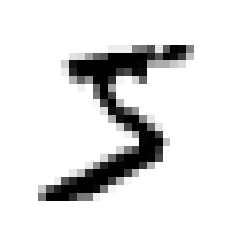

In [ ]:
# 데이터셋에서 이미지 하나 확인
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# 실제 레이블 확인
y[0]

'5'

In [ ]:
# 대부분 머신러닝 알고리즘은 숫자 기대 -> 정수로 변환
import numpy as np
import pandas as pd

y = y.astype(np.uint8)

* 항상 테스트 세트 만들고 훈련 세트와 따로 떼어놓아야해. 훈련 세트는 이미 섞여 있어 모든 교차 검증 폴드를 비슷하게 만들어줘 -> 성능 나빠지는 문제 방지

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 3.2 이진 분류기 훈련

이진 분류기 : 두 개의 클래스 구분

In [ ]:
# 타깃 벡터
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

* 사이킷런의 **SGDClassifier** 클래스 사용해 **확률적 경사 하강법(SGD)** Stochastic Gradient Descent 분류기로 시작
 + 매우 큰 데이터셋 효율적으로 처리(한 번에 하나씩 훈련 샘플 독립적 처리)
 + 훈련하는 데 무작위성 사용 -> 결과 재현하려면 random_state 매개변수 지정

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

교차 검증 => 사이킷런의 **cross_val_score()**

StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행. 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고 테스트 폴드로 예측 만들어 -> 올바른 예측의 수를 세어 정확한 예측의 비율 출력

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


cross_val_score() 함수로 폴드가 3개인 k-겹 교차 검증 사용해 SGDClassifier 모델 평가

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

=> 모든 교차 검증 폴드에 대해 정확도가 95% 이상

모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

=> 정확도가 90% 이상.

=> 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유 보여줘. 특히 불균형한 데이터셋 다룰 때.

### 3.3.2 오차 행렬

**오차 행렬** : 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야해(테스트 세트 사용x) -> **cross_val_predict()** 함수 사용

: k-겹 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측 반환 -> 훈련 세트의 모든 샘플에 대해 깨끗한 예측 얻어

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

**confusion_matrix()** 함수 사용해 오차 행렬 만들어 : 타깃 클래스와 예측 클래스 넣고 호출.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행 = 실제 클래스. 열 = 예측한 클래스

* 첫 번째 행 = 음성 클래스('5 아님' 이미지)
  + 53892개 진짜 음성('5 아님'으로 정확 분류)
  + 687개 거짓 양성('5'라고 잘못 분류)
* 두 번째 행 = 양성 클래스('5' 이미지)
  + 1891개 거짓 음성('5 아님' 잘못 분류)
  + 3530개 진짜 양성('5'라고 정확 분류)

=> 완벽한 분류기라면 진짜 양성과 진짜 음성만 가지고 있어 -> 오차 행렬의 주대각선만 0이 아닌 값

In [ ]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**정밀도** : 양성 예측의 정확도. TP/(TP+FP). TP : 진짜 양성 수. FP : 거짓 양성 수

**재현율=민감도** : 분류기가 정확하게 감지한 양성 샘플의 비율. TP/(TP+FN). FN : 거짓 음성 수

### 3.3.3 정밀도와 재현율

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

=> 5로 판별된 이미지 중 72.9%만 정확. 전체 숫자 5에서 75.6%만 감지

**F1 점수** : 정밀도와 재현율의 조화 평균. F1 = 2/(1/정밀도+1/재현율).**f1_score()** 함수 호출.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 

상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있다. -> 정밀도/재현율 트레이드오프

### 3.3.4 정밀도/재현율 트레이드오프

SGDClassifier는 결정 함수를 사용하여 각 샘플의 점수 계산 -> 임곗값보다 크면 샘플을 양성 클래스에 할당. 그렇지 않으면 음성 클래스에 할당.

사이킷런에서 임곗값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능.

분류기의 **decision_function()**메서드 호출 -> 각 샘플의 점수 얻어 -> 원하는 임곗값 정해 예측 만들 수 o.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

=> 임곗값을 높이면 재현율이 줄어든다

=> 적절한 임곗값을 어떻게 정할 수 있을까? 

**cross_val_predict()** 함수 사용해 훈련 세트에 있는 모든 샘플의 점수 구해

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # 예측 결과가 아니라 결정 점수를 반환받도록 지정

**precision_recall_curve()** 함수 사용해 가능한 모든 임곗값에 대해 정밀도와 재현율 계산

In [ ]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

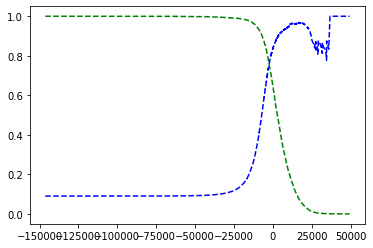

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g--", label="재현율")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # ~7816
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

**ROC 곡선** : 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR). 민감도(재현율)에 대한 1-특이도 그래프

**roc_curve()** 함수 사용해 여러 임곗값에서 TPR과 FPR 계산

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

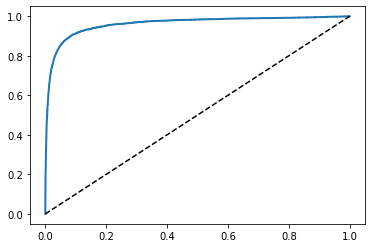

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')  # 대각 점선
  # 축 이름, 그리드 추가

plot_roc_curve(fpr, tpr)
plt.show()

=> 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR) 늘어나. 점선은 완전한 랜덤 분류기의 ROC 곡선. 좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야해(왼쪽 위 모서리)

=> 곡선 아래의 면적(AUC) 측정해 분류기들 비교 **roc_auc_score**

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수 비교 

but decision_function() 메서드 없고 대신 predict_proba() 메서드 o.

-> **predict_proba()**메서드 : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열 반환

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1]  # 양성 클래스에 대한 확률을 점수로 사용합니다.
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47004 (\N{HANGUL SYLLABLE RAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 45924 (\N{HANGUL SYLLABLE DEOM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 47112 (\N{HANGUL SYLLABLE RE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/dist-packages/IPytho

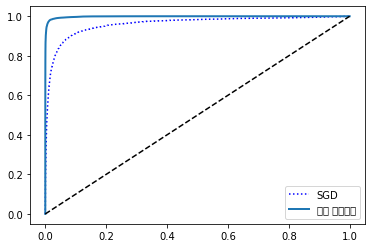

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "랜덤 포레스트")
plt.legend(loc="lower right")
plt.show()

=> RandomForestClassifier의 ROC 곡선이 왼쪽 위 모서리에 더 가까워 SGDClassifier보다 훨씬 좋아 보여. ROC AUC 점수도 훨씬 높아.

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## 3.4 다중 분류

일부 알고리즘(SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기..)은 여러 개의 클래스 직접 처리 가능/ 다른 알고리즘(로지스틱 회귀나 서포트 벡터 머신 분류기..)은 이진 분류만 가능.

* **OvR** 또는 **OvA** : ex) 특정 숫자 하나만 구분하는 숫자별 이진 분류기 10개(0에서부터 9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템

* **OvO** : ex) 각 숫자의 조합마다 이진 분류기를 훈련시키는 것
  + 클래스가 N개라면 분류기는 Nx(N-1)/2개 필요
  + 주요 장점 : 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요하다는 것.

* 일부 알고리즘(서포트 벡터 머신..)은 훈련 세트의 크기에 민감 -> 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빨라 -> OvO 선호
* 대부분의 이진 분류 알고리즘에서는 OvR 선호.


In [ ]:
# sklearn.svm.SVC 클래스 사용해 서포트 벡터 머신 분류기 테스트
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)  # y_train_5가 아니고 y_train을 사용합니다.
svm_clf.predict([some_digit])

array([5], dtype=uint8)

=> 내부에서는 사이킷런이 OvO 전략 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스 선택할 것.

In [ ]:
# decision_function() 메서드 호출하면 샘플당 10개의 점수 반환. 클래스마다 하나씩.
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [ ]:
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 **OneVsOneClassifier**나 **OneVsRestClassifier** 사용

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

=> SVD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR이나 OvO 적용할 필요x.

=> decision_function() 메서드는 클래스마다 하나의 값 반환.

In [ ]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

=> 분류기가 예측 결과에 강한 확신 보이고 있음. 대부분의 점수가 큰 음수.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

=> 모든 테스트 폴드에서 84% 이상. 성능 더 높일 여지o.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

모델 성능 향상시킬 방법 -> 에러의 종류 분석

cross_val_predict() 함수 사용해 예측 만들고 confusion_matrix() 함수 호출

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

오차 행렬을 맷플롯립의 matshow() 함수 사용해 이미지로 표현

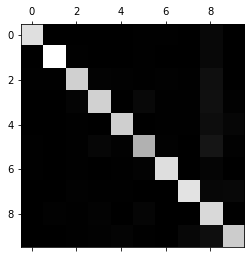

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

=> 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있어 좋아보여.

=> 숫자 5는 조금 더 어두워보여. 데이터셋에 숫자 5의 이미지가 적거나 분류기가 숫자 5를 다른 숫자만큼 잘 분류하지 못하다는 뜻.

In [ ]:
# 에러 비율 비교
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

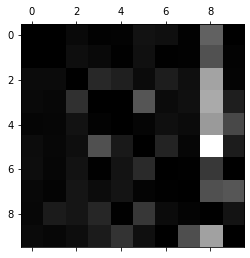

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

=> 행은 실제 클래스. 열은 예측한 클래스./ 오차 행렬은 반드시 대칭인 것x.

=> 오차 행렬 분석하면 분류기의 성능 향상 방안에 대한 통찰 얻을 수 있어.

In [ ]:
# 숫자 그림을 위한 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합침
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합침
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

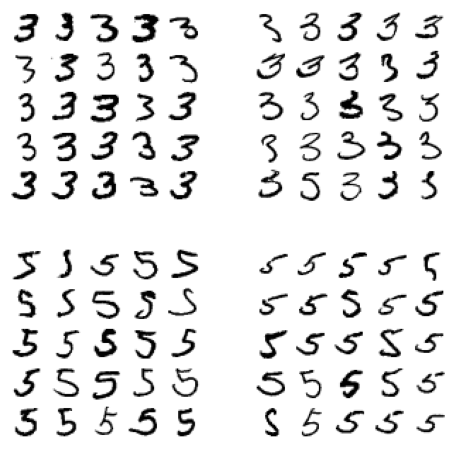

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

=> 분류기가 이미지의 위치나 회전 방향에 매우 민감 -> 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것 -> 다른 에러도 줄어들 것.

## 3.6 다중 레이블 분류

다중 레이블 분류 시스템 : 여러 개의 이진 꼬리표를 출력하는 분류 시스템

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 ==1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# F1 점수로 다중 레이블 분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

=> 모든 레이블의 가중치가 같지 않을 경우 레이블에 클래스의 지지도를 가중치로 두면 돼 average="weighted"로 설정.

## 3.7 다중 출력 분류

다중 출력 다중 클래스 분류 : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화한 것.

In [ ]:
# MNIST 이미지에 randint() 함수 사용해 픽셀 강도에 잡음 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
some_index = 0

# 숫자 이미지를 그리는 함수
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

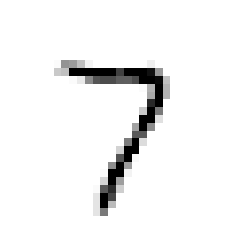

In [ ]:
# 분류기 훈련시켜 이미지 깨끗하게
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)